# FIN41360 Report Notebook (Thin Workflow)

This notebook is intentionally thin: each section calls a named workflow and plotting function.

In [1]:
import seaborn as sns

from fin41360.process_french import load_industry_30_monthly, load_ff3_monthly, load_ff5_monthly
from fin41360.stock_data import load_stock_returns_monthly
from fin41360.workflows import (
    run_scope2_industries_sample_vs_bs,
    run_scope3_industries_vs_stocks,
    run_scope4_industries_with_rf,
    run_scope5_industries_vs_ff,
    run_scope7_is_oos_tests,
)
from fin41360.plot_frontiers import (
    plot_scope2_overlay,
    plot_scope3_overlay,
    plot_scope4_with_rf,
    plot_scope5_overlay,
)

sns.set_theme(style='whitegrid', context='notebook')

In [2]:
# Top-level plotting defaults (change here, applies to all sections)
PLOT_DEFAULTS = {
    "x_mode": "frontier",  # options: frontier | tangency | max
    "y_mode": "frontier",  # options: frontier | tangency | max
    "frontier_mult": 1.2,
    "tan_mult": 2.0,
}
PLOT_DEFAULTS

{'x_mode': 'frontier',
 'y_mode': 'frontier',
 'frontier_mult': 1.2,
 'tan_mult': 2.0}

In [3]:
# Shared data loads
ind = load_industry_30_monthly(start='1980-01', end='2025-12')
ff3, rf_gross = load_ff3_monthly(start='1980-01', end='2025-12')
ff5, rf_gross_ff5 = load_ff5_monthly(start='1980-01', end='2025-12')
stocks = load_stock_returns_monthly(start='1980-01', end='2025-12', use_cache=True)
print('Industries:', ind.shape, ind.index.min().date(), 'to', ind.index.max().date())
print('FF3:', ff3.shape, 'FF5:', ff5.shape, 'RF:', len(rf_gross))
print('Stocks:', stocks.shape, stocks.index.min().date(), 'to', stocks.index.max().date())

Industries: (552, 30) 1980-01-31 to 2025-12-31
FF3: (552, 3) FF5: (552, 5) RF: 552
Stocks: (551, 30) 1980-01-31 to 2025-11-30


## Scope 2 - 30 Industries (Sample vs Bayes-Stein)

In [4]:
scope2 = run_scope2_industries_sample_vs_bs(ind, rf_gross, cov_shrink=0.1)
scope2['inputs']

{'start': '1980-01',
 'end': '2025-12',
 'n_obs': 552,
 'n_assets': 30,
 'rf_mean': 0.003297282608695647}

In [5]:
scope2['summary_tables']['gmv_tan']

,label,universe,portfolio,mean,vol,excess_mean,sharpe
0,sample,industries,GMV,0.009733,0.031396,0.006435,0.204973
1,sample,industries,TAN,0.017633,0.046860,0.014336,0.305928
2,bs_mean,industries,GMV,0.009738,0.031396,0.006441,0.205144
3,bs_mean,industries,TAN,0.017556,0.046715,0.014259,0.305236
4,bs_mean_cov,industries,GMV,0.010071,0.032117,0.006773,0.210897
5,bs_mean_cov,industries,TAN,0.015950,0.043897,0.012653,0.288244


In [6]:
scope2['diagnostics']

{'bs_mean_shrinkage_intensity': 0.004790652563936337,
 'bs_target_mean': 0.010853484299516911,
 'sample_cov_eig_min': 0.000297211524494429,
 'sample_cov_eig_max': 0.07046386709080654,
 'bs_cov_eig_min': 0.0006789347421867802,
 'bs_cov_eig_max': 0.06382892475186769}

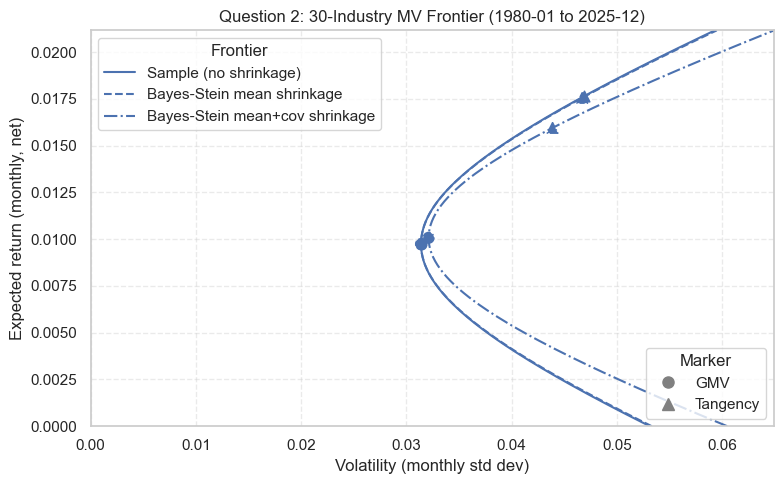

In [7]:
_ = plot_scope2_overlay(scope2, **PLOT_DEFAULTS)


## Scope 3 - 30 Industries vs 30 Stocks (Common Sample)

In [8]:
scope3 = run_scope3_industries_vs_stocks(ind, stocks, rf_gross, cov_shrink=0.1)
scope3['inputs']

{'common_start': '2019-04',
 'common_end': '2025-11',
 'n_obs': 80,
 'n_assets_industry': 30,
 'n_assets_stock': 30,
 'rf_mean': 0.002148750000000005}

In [9]:
scope3['summary_tables']['gmv_tan']

,estimator,universe,portfolio,mean,vol,excess_mean,sharpe
0,sample,industry,GMV,0.004098,0.026489,0.001949,0.073578
1,sample,industry,TAN,0.327230,0.342104,0.325081,0.950240
2,sample,stock,GMV,0.003460,0.030070,0.001311,0.043610
3,sample,stock,TAN,0.470308,0.568159,0.468159,0.823994
4,bs_mean,industry,GMV,0.004129,0.026489,0.001980,0.074748
5,bs_mean,industry,TAN,0.319723,0.335474,0.317575,0.946646
6,bs_mean,stock,GMV,0.003522,0.030070,0.001373,0.045674
7,bs_mean,stock,TAN,0.442262,0.538284,0.440114,0.817623
8,bs_mean_cov,industry,GMV,0.006183,0.030686,0.004034,0.131477
9,bs_mean_cov,industry,TAN,0.114173,0.161696,0.112024,0.692808


In [10]:
scope3['diagnostics']

{'bs_industry_shrinkage_intensity': 0.003902500292214437,
 'bs_stock_shrinkage_intensity': 0.007891184549728498,
 'note': 'Scope 3 frontiers are estimated on overlapping dates with complete data.'}

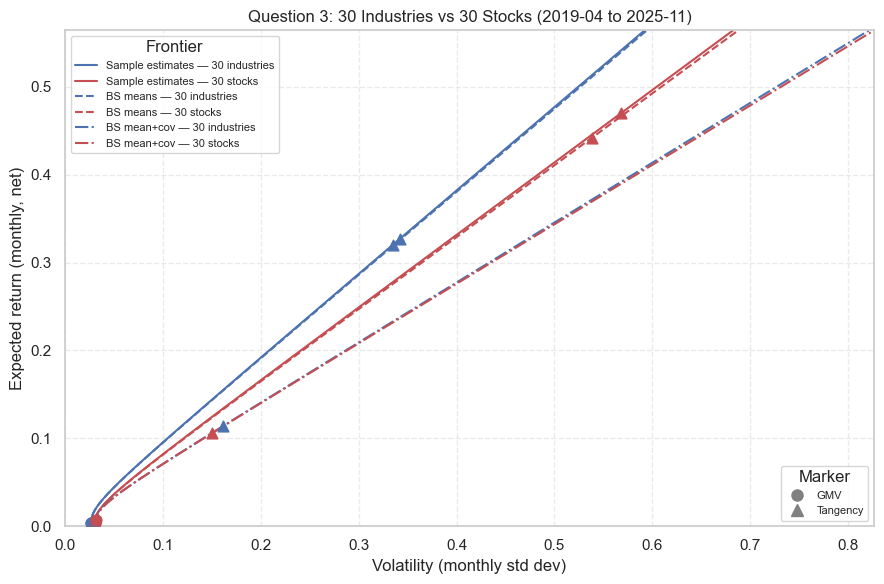

In [11]:
_ = plot_scope3_overlay(scope3, **PLOT_DEFAULTS)


## Scope 4 - 30 Industries + Risk-Free Asset

In [12]:
scope4 = run_scope4_industries_with_rf(ind, rf_gross)
scope4['inputs']

{'start': '1980-01',
 'end': '2025-12',
 'n_obs': 552,
 'n_assets': 30,
 'rf_mean': 0.003297282608695647}

In [13]:
scope4['summary_tables']['gmv_tan']

,universe,portfolio,mean,vol,excess_mean,sharpe
0,industries,GMV,0.009733,0.031396,0.006435,0.204973
1,industries,TAN,0.017633,0.046860,0.014336,0.305928


In [14]:
scope4['diagnostics']

{'note': 'Scope 4 efficient set combines risky frontier and CML through tangency.'}

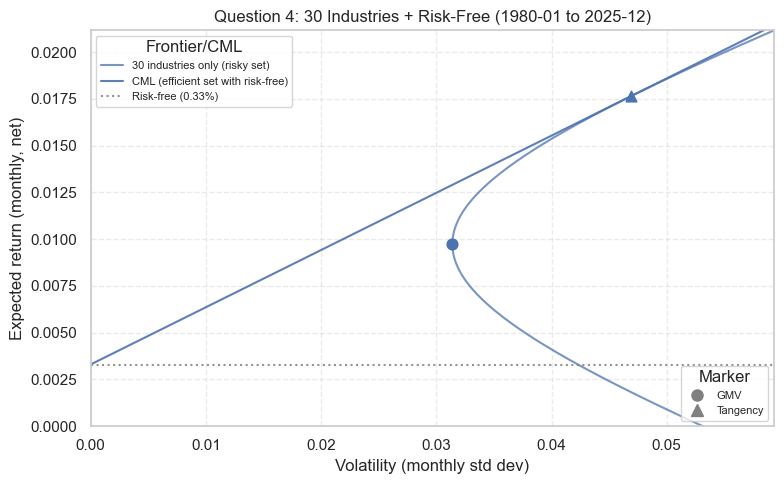

In [15]:
_ = plot_scope4_with_rf(scope4)


## Scope 5 - Industries vs FF3 vs FF5 (Excess Space)

In [16]:
scope5 = run_scope5_industries_vs_ff(ind, ff3, ff5, rf_gross)
scope5['inputs']

{'start': '1980-01',
 'end': '2025-12',
 'n_obs': 552,
 'space': 'excess returns (rf=0)'}

In [17]:
scope5['summary_tables']['gmv_tan']

,series,universe,portfolio,mean,vol,excess_mean,sharpe
0,industries,industries,GMV,0.006419,0.031293,0.006419,0.205124
1,industries,industries,TAN,0.014287,0.046686,0.014287,0.306029
2,ff3,ff3,GMV,0.002278,0.017905,0.002278,0.127250
3,ff3,ff3,TAN,0.005357,0.027456,0.005357,0.195126
4,ff5,ff5,GMV,0.002926,0.010810,0.002926,0.270663
5,ff5,ff5,TAN,0.003796,0.012313,0.003796,0.308290


In [18]:
scope5['diagnostics']

{'note': 'Industries are converted to excess returns before comparison to FF3/FF5.'}

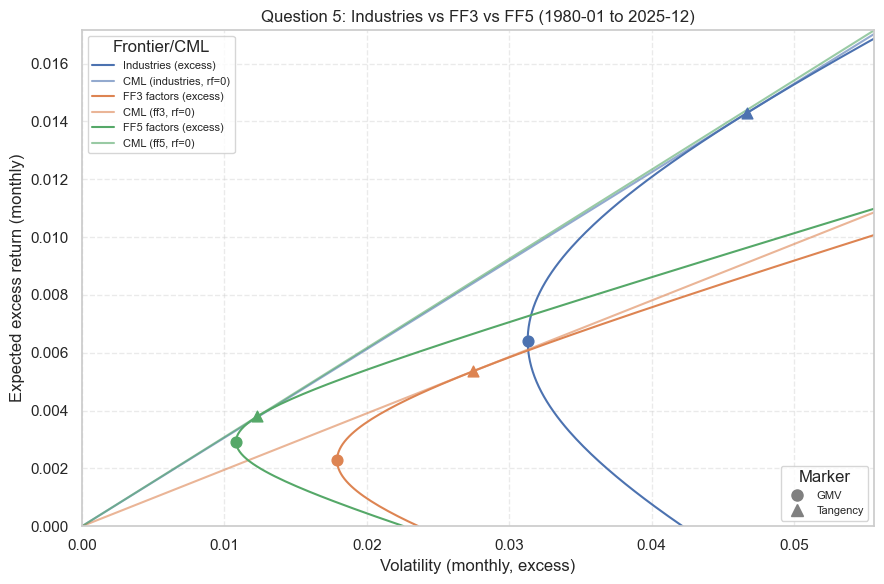

In [19]:
_ = plot_scope5_overlay(scope5)


## Scope 7 - In-sample / Out-of-sample Sharpe Stability

In [20]:
scope7 = run_scope7_is_oos_tests(ind_gross=ind, ff5_excess=ff5, rf_gross=rf_gross, end_is='2002-12', start_oos='2003-01', end_oos='2025-12')
scope7['inputs']

{'end_is': '2002-12',
 'start_oos': '2003-01',
 'end_oos': '2025-12',
 'industry_is_start': '1980-01',
 'industry_is_end': '2002-12',
 'industry_oos_start': '2003-01',
 'industry_oos_end': '2025-12',
 'ff5_is_start': '1980-01',
 'ff5_is_end': '2002-12',
 'ff5_oos_start': '2003-01',
 'ff5_oos_end': '2025-12',
 'n_ind_is': 276,
 'n_ind_oos': 276,
 'n_ff5_is': 276,
 'n_ff5_oos': 276,
 'rf_ind_is_mean': 0.005246739130434777,
 'rf_ind_oos_mean': 0.0013478260869565174}

In [21]:
scope7['summary_tables']['is_points']

,portfolio,asset_set,mean_is,vol_is,sharpe_is
0,30 ind TAN,industries,0.025766,0.060917,0.337291
1,30 ind GMV,industries,0.010694,0.031386,0.174352
2,FF5 TAN,ff5_excess,0.004326,0.010829,0.399498
3,FF5 GMV,ff5_excess,0.003892,0.010271,0.378917


In [22]:
scope7['summary_tables']['sharpe_is_oos']

,portfolio,sr_is,sr_oos,delta
0,30 ind TAN,0.337291,0.081338,-0.255953
1,30 ind GMV,0.174352,0.165024,-0.009328
2,FF5 TAN,0.399498,0.198728,-0.200770
3,FF5 GMV,0.378917,0.178208,-0.200709


In [23]:
scope7['summary_tables']['jk_tests']

,portfolio,sr_is,sr_oos,z_stat,pvalue
0,30 ind TAN,0.336835,0.081486,2.955630,0.003120
1,30 ind GMV,0.173547,0.165300,0.096195,0.923365
2,FF5 TAN,0.399498,0.198728,2.301921,0.021340
3,FF5 GMV,0.378917,0.178208,2.307759,0.021013


In [24]:
scope7['summary_tables']['lw_tests']

,portfolio,sr_is,sr_oos,diff,ci_low,ci_high,pvalue
0,30 ind TAN,0.336835,0.081486,0.255349,0.108593,0.413792,0.001
1,30 ind GMV,0.173547,0.165300,0.008247,-0.167657,0.178053,0.930
2,FF5 TAN,0.399498,0.198728,0.200770,0.026749,0.396846,0.022
3,FF5 GMV,0.378917,0.178208,0.200709,0.006381,0.392572,0.039


In [25]:
scope7['summary_tables']['frontier_replication']

,portfolio,alpha,r_squared,residual_norm
0,30 ind TAN,1.225348,0.111570,1.793423
1,30 ind GMV,0.965520,-0.073564,0.833263
2,FF5 TAN,0.807486,0.110720,0.282608
3,FF5 GMV,0.968557,-0.015018,0.238164


## Next Sections

Scope 6 plotting/workflow migration is next. Scope 8 and Scope 9 are required and will be migrated in a later tranche.